
# <center> **GANS - Generative Adversial Networks** </center>
“The most interesting idea in the last 10 years in Machine Learning”. Yann LeCun


## <span style="color:red"> Outline </span>
1. **Why GANS?**
2. **GANS: Generative Adversial Networks**
3. **Implementing a vanilla GAN**




In [3]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [4]:
#@title Load libraries and remember to configurate notebook in GPU


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

!pip install -q imageio
import glob
import imageio
import PIL
import time
from IPython import display

import cv2

import tensorflow as tf

from keras.models import Model, load_model
from tensorflow.keras import layers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

ModuleNotFoundError: No module named 'keras.layers.core'

# **1. Why GANS?**

A new kind of generative models are introduced into deep learning context, named GANs (**G**enerative **A**dversarial **N**etwoorks). In recent years, these models have demostrated impresive results in many different applications, such as:

- Generate human faces
- Style transfer
- Video prediction
- Generate Cartoon Characters
- new example beedrooms
- Arithmetic with the input to the GANs
- Generate anime characters
- Face aging
- among many much others ....



<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Gans/gan_application.png?raw=true" width="1000">
</center>



#**2. GANS: Generative Adversial Networks**

Gans consist on **two networks (generator and discriminatori)** train and compete against each other, resulting in mutual updating. In such case, the generatoris try **to produce** new pausible examples and the discriminator try **to differentiate** generated examples from real examples, each time more challenging. This training follows a **Game theory** as minimax game, knows as **an adversarial process**. So, we have:


<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Gans/gans_intro.png?raw=true" width="1000">
</center>


- **Generator net G(Z)** takes input random noise  and try to generate images. This generator capture the propability $P(X,Y)$ or simply $P(X)$. The generator misleads the discriminator by creating close images with respect to real ones. Formally:

$$\mathcal{L}_{G}^{GAN} = \mathop{min}_{G}E_{x_g \sim P_{g}(x)} [ log(1 - D(x_g)) ]$$

- **Discriminator net D(X)** take input and try to differentiate between real and falke images. This generator capture the probability $P(Y|X)$. Each time the discriminator learn to better differentiate fake to real images. Discriminator finish training ideally when output the probability of 0.5 in real and fake images. Formally


$$ \mathcal{L}_{D}^{GAN} = \mathop{max}_{D}E_{x_r \sim P_{r}(x)} [ log(D(x_r)) ] + E_{x_g \sim p_{g}(x)} [ log(1 - D(x_g)) ]$$


Regarding training model, the discriminator learn from real and fake inputs, while the whole model is built with the discriminator combined with the generator.

**GO to the action!**

        


#**3. Implementing a vanilla GAN**



In [5]:
#@title Load image toy dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
#@markdown ### **3.1 Generator model**

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  model.summary()

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

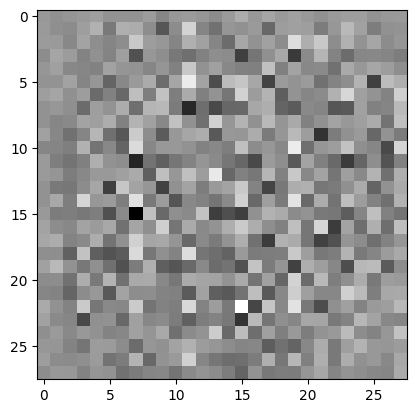

In [8]:
#@title **code** from a random vector (normal distribution) to a image

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
#@markdown ### **3.2 Discriminator model**
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  model.summary()

  return model

In [10]:
#@title **code** generated img to discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

tf.Tensor([[0.00573699]], shape=(1, 1), dtype=float32)


In [11]:
#@markdown ### **3.3 Loss functions and optimizers**
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
#@title **code** training and check-points
!mkdir /content/drive/MyDrive/Academia40/Notebooks/checkpoints/training_checkpoints
checkpoint_dir = '/content/drive/MyDrive/Academia40/Notebooks/checkpoints/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
#@title Defining the training loop
EPOCHS =  50#@param {type:"integer"}
noise_dim = 100#@param {type:"integer"}
num_examples_to_generate = 16#@param {type:"integer"}

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
#@title Now, this function (from tf doc) update weights according to loss function
# Notice the use of `tf.function`

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [27]:
#@title **code** train and save epochs
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [28]:
#@title **code** Generating images
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('/content/drive/MyDrive/Academia40/Notebooks/imgs/gans_ep/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [29]:
#@title **code** Display img per epoch
def display_image(epoch_no):
  return PIL.Image.open('/content/drive/MyDrive/Academia40/Notebooks/imgs/gans_ep/image_at_epoch_{:04d}.png'.format(epoch_no))

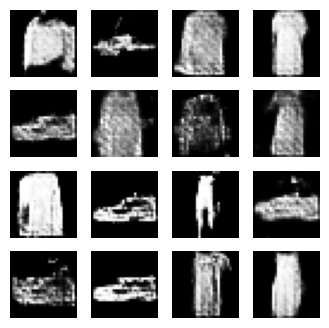

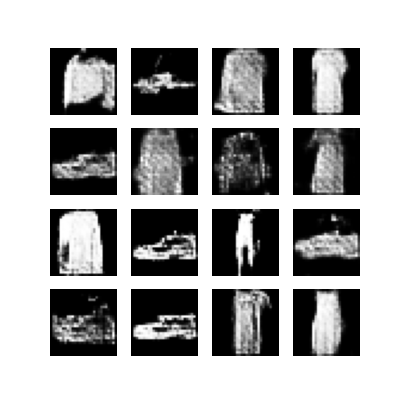

In [30]:
#@title **code** Finally, we train the model
train(train_dataset, EPOCHS)
display_image(EPOCHS)

interactive(children=(IntSlider(value=0, description='index', max=49), Output()), _dom_classes=('widget-intera…

<function __main__.plot_with_pil(index)>

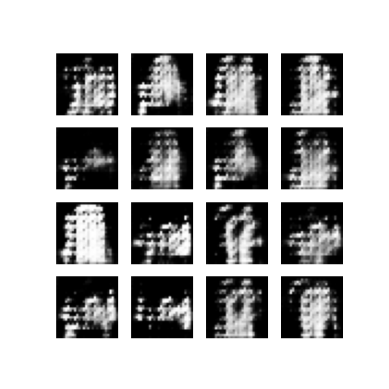

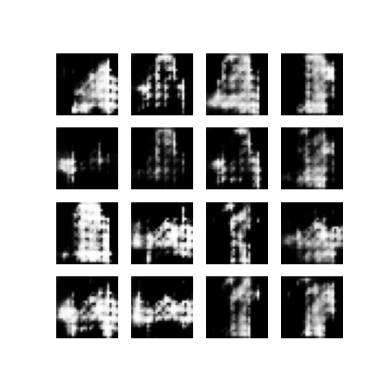

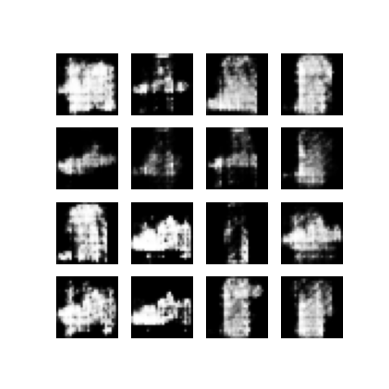

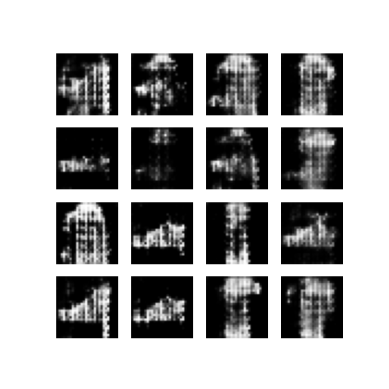

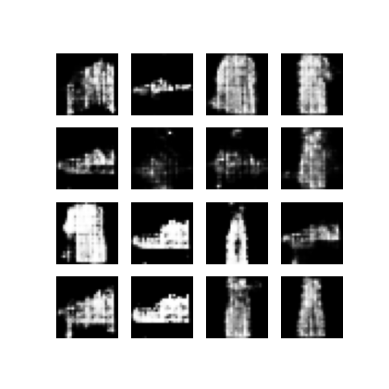

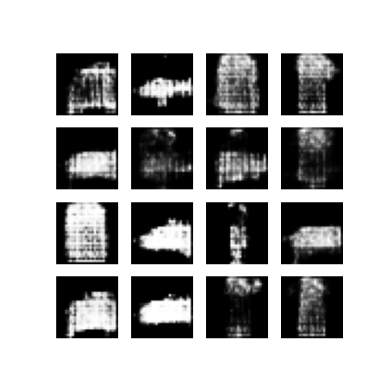

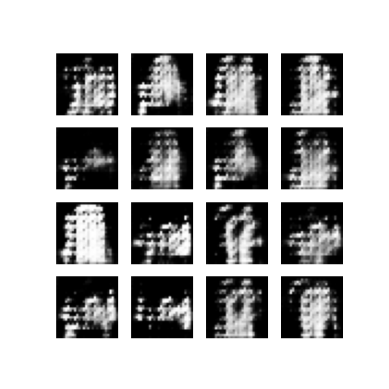

In [32]:
#@title **code** To visualize the results.
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


path = '/content/drive/MyDrive/Academia40/Notebooks/imgs/gans_ep/'
files = [f for f in os.listdir(path) if f[-3:] == 'png']

def plot_with_pil(index):
    img = None
    image_file = os.path.join(path, files[index]);
    im=plt.imread(image_file);
    plt.axis('off')
    if img is None:
        img = plt.imshow(im);
    else:
        img.set_data(im);

interact(plot_with_pil, index = widgets.IntSlider(min=0,max=len(files)-1,step=1,value=0))

In [37]:
#@title **code** create a GIF
anim_file = '/content/drive/MyDrive/Academia40/Notebooks/imgs/gans_ep/dcgan_mnist.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('imgs/gans_ep/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)




**CHALLENGE**

- Use more ephochs and visualize additional images (more than 16)
- Now, modify the architecture and try with CIFAR-10
- Use additional convolutional layers and change the optimizer

- Taller.  Generate new cars!. Try a Gan architecture from this dataset https://www.tensorflow.org/datasets/catalog/cars196


## **To be  continued! ..**
<center>
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/Gans/gans_arch.png?raw=true" width="1000">
</center>


## **Some conclusions**

- Each day novel applications emerge from generative models that could evolve in new task and challenges.

- Despite the remarkably advances on IA, many of DL applications requires huge data to obtain proper representations.

- GANs are computationally expensive. For instance, some of the fake celebrity faces, after several epochs on 8 Tesla V 100 GPU’s take 4 days



## **References**

[1. Generative Adversarial Networks. Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio](https://arxiv.org/abs/1406.2661)

[2. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)

[3. Towards the Automatic Anime Characters Creation with Generative Adversarial Networks](https://arxiv.org/abs/1708.05509)

[4. Face aging with conditional generative adversarial networks](https://ieeexplore.ieee.org/document/8296650)